In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from spcqe.quantiles import SmoothPeriodicQuantiles
# PVInsight Code Imports
from solardatatools import DataHandler
from solardatatools.dataio import load_cassandra_data

In [3]:
siteid = 'TADBC1078041' # classic "winter shade" pattern
df = load_cassandra_data(siteid)

Query of 193051 rows complete in 4.84 seconds


In [4]:
df.head()

,SiteID,ac_current,ac_power,ac_voltage,ambient_temp,dc_current,dc_power,dc_voltage,inverter_error_code,inverter_temp,module_temp,poa_irradiance,power_factor,relative_humidity,wind_direction,wind_speed
2011-01-01 00:00:00,34.0,0.0,-200.0,284.0,-3.353332,0.0,-200.0,16.0,0.0,37.0,-7.105555,0.0,0.0,53.513,315.270,0.483250
2011-01-01 00:15:00,34.0,0.0,-300.0,284.0,-3.381110,0.0,-200.0,16.0,0.0,36.0,-6.944444,0.0,0.0,53.581,308.835,0.698724
2011-01-01 00:30:00,34.0,0.0,-300.0,284.0,-3.257777,0.0,-200.0,16.0,0.0,36.0,-6.344444,0.0,0.0,53.413,272.678,0.218156
2011-01-01 00:45:00,34.0,0.0,-200.0,283.0,-3.296666,0.0,0.0,15.0,0.0,36.0,-6.655555,0.0,0.0,52.406,55.913,0.159146
2011-01-01 01:00:00,34.0,0.0,-300.0,284.0,-3.426110,0.0,-200.0,14.0,0.0,35.0,-7.405555,0.0,0.0,53.588,152.145,0.240508


### Running the `DataHandler` processing pipeline

In [5]:
dh = DataHandler(data_frame)

In [6]:
dh.run_pipeline(power_col='ac_power', solver='MOSEK')

total time: 2.05 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              1.31s
Cleaning                   0.06s
Filtering/Summarizing      0.67s
    Data quality           0.06s
    Clear day detect       0.11s
    Clipping detect        0.09s
    Capacity change detect 0.40s



In [7]:
dh.report()


-----------------
DATA SET REPORT
-----------------
length               4.00 years
capacity estimate    107.10 kW
data sampling        15 minutes
quality score        0.96
clearness score      0.55
inverter clipping    False
clipped fraction     0.00
capacity changes     False
data quality warning True
time shift errors    False
time zone errors     False
            


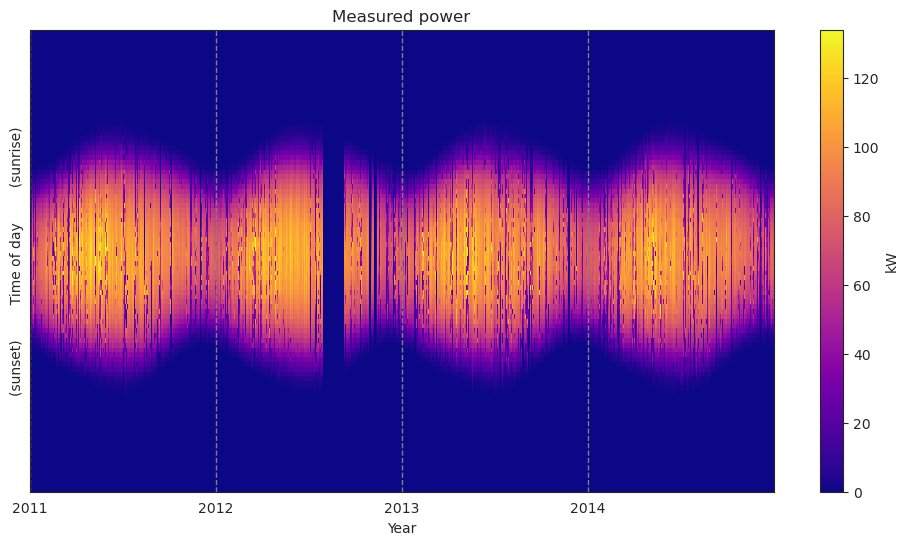

In [8]:
dh.plot_heatmap('filled');

<Axes: >

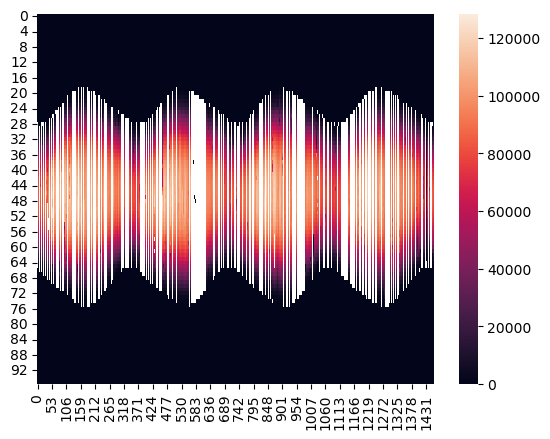

In [38]:
data = np.copy(dh.raw_data_matrix)
data[:, dh.daily_flags.cloudy] = np.nan
msk = dh.daytime_analysis.sunup_mask_estimated
data[~msk] = 0
y = data.ravel(order='F')
sns.heatmap(data)

In [73]:
P1 = int(365*24*4)
P2 = int(24*4)
K = 6
l = 0.1
spq = SmoothPeriodicQuantiles(K, [P1, P2], quantiles=.7, weight=l, take_log=False, verbose=True)
spq

SmoothPeriodicQuantiles(num_harmonics=6, periods=[35040, 96],
                        quantiles=array([0.7]), verbose=True, weight=0.1)

In [74]:
spq.fit(y)

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
problem size:                    280682 variables
initial factorization time:      8.12e+00s
(standard algorithm)

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 5.26e+01    1.37e+00     1.01e+00   [0.5  0.02]  1.87e-01
   25 | 1.61e+03    5.34e-02     2.59e-02   [0.5  0.02]  5.02e+00
   50 | 1.73e+03    2.96e-02     1.40e-02   [0.5  0.02]  1.02e+01
   75 | 1.77e+03    2.13e-02     7.75e-03   [0.5  0.02]  1.52e+01
  100 | 1.80e+03    1.39e-02     5.60e-03   [0.5  0.02]  2.04e+01
  125 | 1.81e+03    1.18e-02     5.57e-03  

In [75]:
fixed_quantiles = spq.fit_quantiles.reshape(dh.filled_data_matrix.shape, order='F')
fixed_quantiles[~dh.daytime_analysis.sunup_mask_estimated] = 0

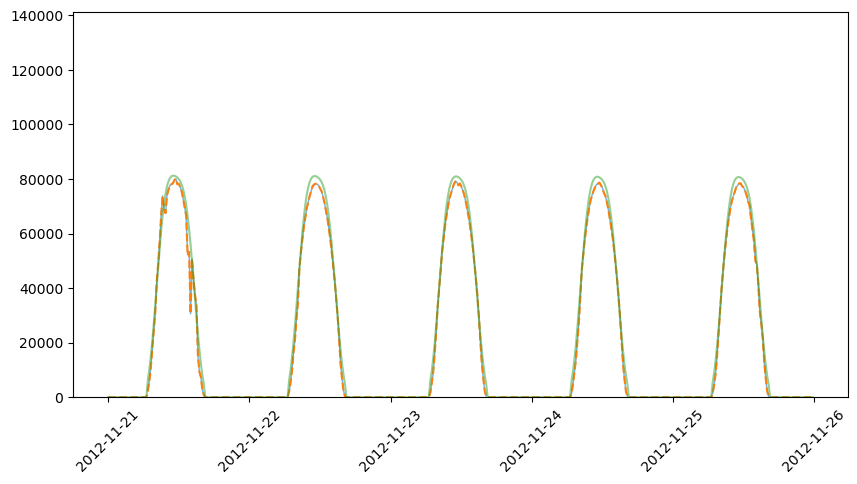

In [89]:
ix = 690
slc = np.s_[24 * 4 * ix:24 * 4 * (ix + 5)]
xs = data_frame.index[slc]
plt.figure(figsize=(10,5))
plt.plot(xs, dh.raw_data_matrix.ravel(order='F')[slc], linewidth=1, alpha=0.6)
plt.plot(xs, y[slc], ls='--')
plt.plot(xs, fixed_quantiles.ravel(order='F')[slc], alpha=0.5)
plt.ylim(-10, np.nanmax(y)*1.1)
plt.xticks(rotation=45);

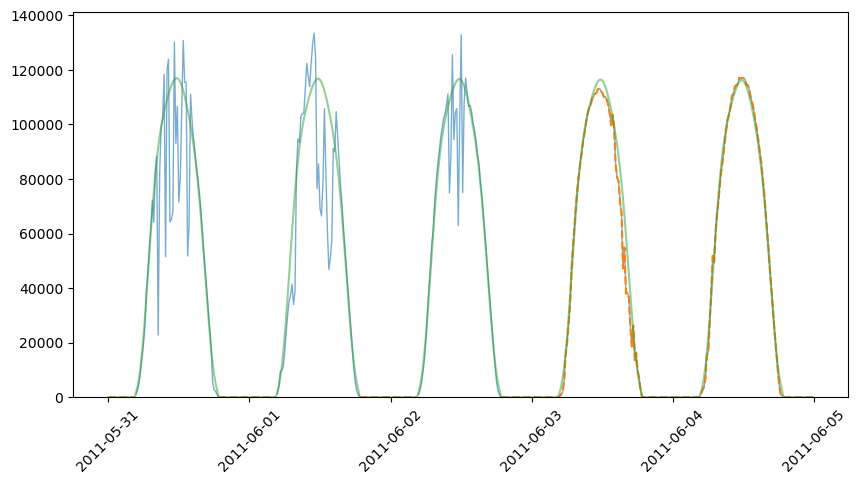

In [72]:
ix = 150
slc = np.s_[24 * 4 * ix:24 * 4 * (ix + 5)]
xs = data_frame.index[slc]
plt.figure(figsize=(10,5))
plt.plot(xs, dh.raw_data_matrix.ravel(order='F')[slc], linewidth=1, alpha=0.6)
plt.plot(xs, y[slc], ls='--')
plt.plot(xs, fixed_quantiles.ravel(order='F')[slc], alpha=0.5)
plt.ylim(-10, np.nanmax(y)*1.1)
plt.xticks(rotation=45);

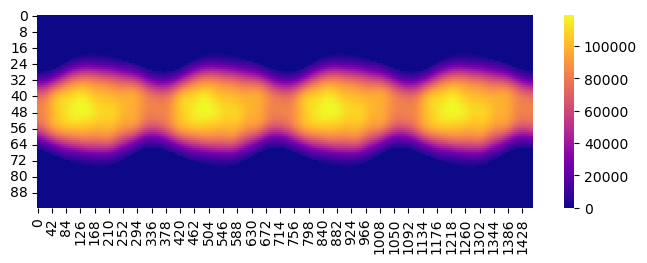

In [44]:
plt.figure(figsize=(8,2.5))
sns.heatmap(fixed_quantiles, cmap='plasma', ax=plt.gca());

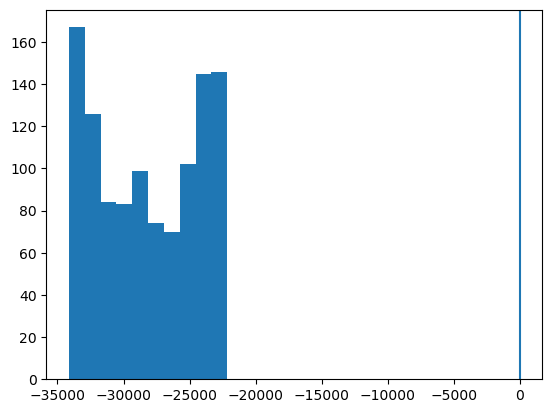

In [52]:
de = np.sum(fixed_quantiles, axis=0)
plt.hist(100*(de[365:] - de[:-365]))
plt.axvline(dh.scsf.degradation_rate());

In [22]:
dh.fit_statistical_clear_sky_model(verbose=True)

----------------------
SCSF Problem Setup
----------------------
Matrix Size: 96 x 1461 = 140256 power measurements
Sparsity: 72.93%
37971 non-zero measurements under clear conditions
Model size: 96 x 6 + 6 x 1461 = 9342 parameters


----------------------
Algorithm Iterations
----------------------
Starting at Objective: 9.541e+09, f1: 3.836e+07, f2: 4.433e+02, f3: 7.190e+09, f4: 2.313e+09
    Minimizing left matrix


/Users/bennetm/miniconda3/envs/spcqe-dev/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


    Minimizing right matrix
1 - Objective: 3.713e+07, f1: 3.496e+07, f2: 4.111e+02, f3: 2.167e+06, f4: 2.072e-02
    Minimizing left matrix
    Minimizing right matrix
2 - Objective: 3.241e+07, f1: 3.021e+07, f2: 1.386e+03, f3: 2.200e+06, f4: 9.689e-06
    Minimizing left matrix
    Minimizing right matrix
3 - Objective: 3.218e+07, f1: 2.999e+07, f2: 1.387e+03, f3: 2.195e+06, f4: 3.894e-07
    Minimizing left matrix
    Minimizing right matrix
4 - Objective: 3.216e+07, f1: 2.996e+07, f2: 1.399e+03, f3: 2.192e+06, f4: 9.306e-06
Minimization complete in 0.27 minutes


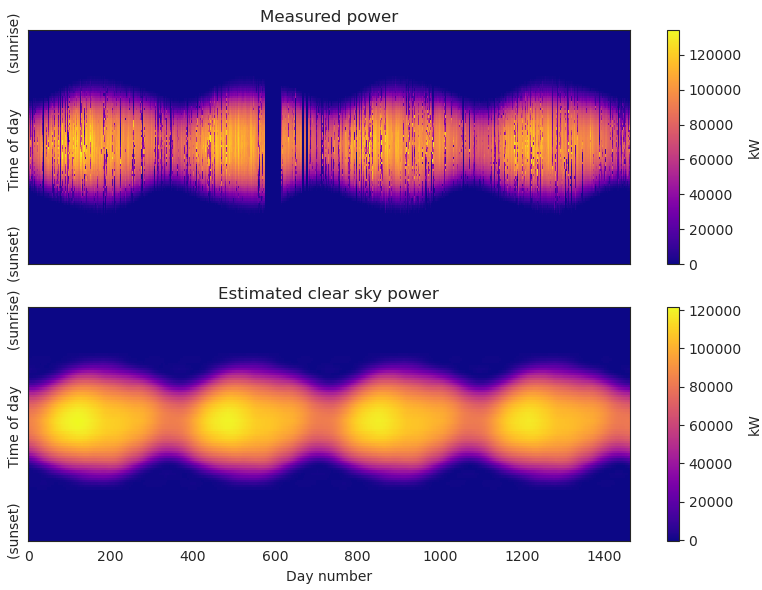

In [47]:
dh.scsf.plot_measured_clear_matrices(figsize=(8, 6));

In [49]:
dh.scsf.degradation_rate()

array(-0.01211933)